# Лабораторна робота 5 (ML)
## Реалізація багатошарового перцептрону з нуля в PyTorch

У цій лабораторній роботі ми:
1. Готуємо дані з **Wine Quality Dataset**.
2. Реалізуємо з нуля функції активації.
3. Реалізуємо з нуля функцію втрат **Softmax + Categorical Cross-Entropy**.
4. Реалізуємо власний клас `CustomMLP` без використання `autograd`.
5. Реалізуємо еталонну модель `PyTorchMLP` на базі `nn.Module`.
6. Порівнюємо якість моделей, візуалізуємо історію навчання та матриці неточностей.
7. Відповідаємо на теоретичні питання.

> **Примітка:** перед запуском коду завантажте CSV-файл датасету з Kaggle
> (датасет `yasserh/wine-quality-dataset`) і покладіть його в цю ж папку.
> У коді за замовчуванням використовується шлях `'WineQT.csv'`. За потреби змініть його.

## 1. Імпорти та базові налаштування

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cpu')
device

device(type='cpu')

## 2. Підготовка даних

Функція `load_and_preprocess_data` виконує кроки з інструкції:
1. Завантажує CSV з даними про вино.
2. Відокремлює ознаки `X` та мітки `y`.
3. Нормалізує ознаки за допомогою `StandardScaler`.
4. Розділяє дані на тренувальну/валідаційну/тестову вибірки.
5. Конвертує дані у тензори PyTorch.

In [2]:
def load_and_preprocess_data(csv_path: str = 'WineQT.csv',
                              test_size: float = 0.2,
                              val_size: float = 0.2):
    """Завантаження та попередня обробка Wine Quality Dataset.

    Параметри:
        csv_path: шлях до CSV-файлу з датасетом.
        test_size: частка тестової вибірки.
        val_size: частка валідаційної вибірки відносно train.
    Повертає:
        X_train, y_train, X_val, y_val, X_test, y_test, class_names
    """
    df = pd.read_csv(csv_path)

    # Припускаємо, що стовпець якості називається 'quality'
    X = df.drop(columns=['quality']).values.astype(np.float32)
    y_raw = df['quality'].values

    # Перетворюємо мітки якості у 0..C-1
    unique_labels = np.sort(np.unique(y_raw))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_to_index[label] for label in y_raw], dtype=np.int64)

    class_names = [str(label) for label in unique_labels]

    # Train / test спліт
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Train / val спліт
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
    )

    # Масштабування ознак
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Конвертуємо у тензори
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

    y_train = torch.tensor(y_train, dtype=torch.long, device=device)
    y_val = torch.tensor(y_val, dtype=torch.long, device=device)
    y_test = torch.tensor(y_test, dtype=torch.long, device=device)

    return X_train, y_train, X_val, y_val, X_test, y_test, class_names


# Швидка перевірка форми даних (запустіть після того, як завантажите CSV)
try:
    X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_and_preprocess_data()
    print('Форми тензорів:')
    print('X_train:', X_train.shape, 'y_train:', y_train.shape)
    print('X_val:', X_val.shape, 'y_val:', y_val.shape)
    print('X_test:', X_test.shape, 'y_test:', y_test.shape)
    print('Кількість класів:', len(class_names), '->', class_names)
except FileNotFoundError:
    print('⚠️ Файл WineQT.csv не знайдено. Завантажте його з Kaggle і покладіть в цю папку.')

Форми тензорів:
X_train: torch.Size([731, 12]) y_train: torch.Size([731])
X_val: torch.Size([183, 12]) y_val: torch.Size([183])
X_test: torch.Size([229, 12]) y_test: torch.Size([229])
Кількість класів: 6 -> ['3', '4', '5', '6', '7', '8']


## 3. Функції активації (реалізація з нуля)

Клас `ActivationFunctions` містить реалізації `ReLU` та `tanh`.
Кожна функція має режим `derivative=True` для обчислення похідної під час backpropagation.

In [3]:
class ActivationFunctions:
    @staticmethod
    def relu(x: torch.Tensor, derivative: bool = False) -> torch.Tensor:
        """ReLU: f(x) = max(0, x)

        Похідна: 1 для x > 0, 0 для x <= 0
        """
        if derivative:
            return (x > 0).float()
        else:
            return torch.clamp(x, min=0.0)

    @staticmethod
    def tanh(x: torch.Tensor, derivative: bool = False) -> torch.Tensor:
        """Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))

        Похідна: 1 - tanh²(x)
        """
        if derivative:
            return 1 - torch.tanh(x) ** 2
        else:
            return torch.tanh(x)


## 4. Функція втрат (реалізація з нуля)

Реалізуємо **Categorical Cross-Entropy** для багатокласової класифікації.
Ми працюємо з логітами вихідного шару, до яких застосовано softmax.

Оптимізована похідна для зв'язки softmax + cross-entropy:
\[ \nabla_z L = y_{pred} - y_{true} \]
де `y_true` — one-hot представлення справжніх міток.

In [4]:
class LossFunctions:
    @staticmethod
    def categorical_cross_entropy(y_pred: torch.Tensor,
                                  y_true: torch.Tensor,
                                  derivative: bool = False) -> torch.Tensor:
        """Категоріальна крос-ентропія.

        Параметри:
            y_pred: ймовірності класів після softmax, розмір [batch_size, num_classes]
            y_true: індекси правильних класів, розмір [batch_size]
        """
        batch_size = y_pred.shape[0]

        if not derivative:
            eps = 1e-12
            # уникаємо log(0)
            clipped = torch.clamp(y_pred, eps, 1.0 - eps)
            log_probs = torch.log(clipped)
            loss = -log_probs[torch.arange(batch_size, device=y_true.device), y_true].mean()
            return loss
        else:
            # Градієнт для softmax + cross-entropy
            grad = y_pred.clone()
            grad[torch.arange(batch_size, device=y_true.device), y_true] -= 1.0
            grad = grad / batch_size
            return grad


## 5. Власна реалізація MLP (без autograd)

Клас `CustomMLP` реалізує:
- ініціалізацію ваг методом **Xavier**;
- прямий прохід `forward` з кешуванням `Z` та `A` для кожного шару;
- зворотний прохід `backward` з використанням ланцюгового правила;
- оновлення ваг та зміщень за градієнтним спуском.

In [5]:
class CustomMLP:
    def __init__(self, layer_sizes, activations, learning_rate: float = 0.01):
        """Власний MLP без autograd.

        layer_sizes: список розмірностей шарів, наприклад [input_dim, 64, 32, num_classes]
        activations: список назв активацій для прихованих та вихідного шару,
                     наприклад ['relu', 'relu', 'softmax']
        learning_rate: швидкість навчання
        """
        assert len(layer_sizes) >= 2, 'Має бути хоча б вхідний і вихідний шар.'
        assert len(activations) == len(layer_sizes) - 1, 'Кількість активацій має дорівнювати кількості шарів-1.'

        self.layer_sizes = layer_sizes
        self.activations = activations
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes) - 1
        self.parameters = {}

        self._init_parameters_xavier()

    def _init_parameters_xavier(self):
        """Ініціалізація ваг методом Xavier для кожного шару."""
        for i in range(1, len(self.layer_sizes)):
            in_dim = self.layer_sizes[i - 1]
            out_dim = self.layer_sizes[i]
            limit = np.sqrt(6.0 / (in_dim + out_dim))

            W = torch.empty((out_dim, in_dim), dtype=torch.float32, device=device).uniform_(-limit, limit)
            b = torch.zeros((out_dim, 1), dtype=torch.float32, device=device)

            self.parameters[f'W{i}'] = W
            self.parameters[f'b{i}'] = b

    def _apply_activation(self, Z: torch.Tensor, name: str, derivative: bool = False) -> torch.Tensor:
        if name == 'relu':
            return ActivationFunctions.relu(Z, derivative=derivative)
        elif name == 'tanh':
            return ActivationFunctions.tanh(Z, derivative=derivative)
        elif name == 'softmax':
            if derivative:
                raise ValueError('Похідна softmax окремо не використовується — вона врахована в LossFunctions.')
            # стабільний softmax по стовпцях (batch по стовпцях)
            Z_stable = Z - Z.max(dim=0, keepdim=True).values
            exp_Z = torch.exp(Z_stable)
            return exp_Z / exp_Z.sum(dim=0, keepdim=True)
        else:
            raise ValueError(f'Невідома активація: {name}')

    def forward(self, X: torch.Tensor, training: bool = True):
        """Прямий прохід через мережу.

        X: [batch_size, input_dim]
        Повертає:
            y_pred: [batch_size, num_classes]
            cache: словник з A і Z для всіх шарів
        """
        A_prev = X.T  # [input_dim, batch_size]
        cache = {'A0': A_prev}

        for i in range(1, self.num_layers + 1):
            W = self.parameters[f'W{i}']
            b = self.parameters[f'b{i}']
            Z = W @ A_prev + b  # [out_dim, batch_size]
            cache[f'Z{i}'] = Z

            act_name = self.activations[i - 1]
            if i == self.num_layers and act_name == 'softmax':
                A = self._apply_activation(Z, 'softmax')
            else:
                A = self._apply_activation(Z, act_name)

            cache[f'A{i}'] = A
            A_prev = A

        # Вихід повертаємо в розмірі [batch_size, num_classes]
        y_pred = cache[f'A{self.num_layers}'].T
        return y_pred, cache

    def backward(self, X: torch.Tensor, y: torch.Tensor, cache: dict):
        """Зворотний прохід і оновлення параметрів.

        1. Обчислюємо градієнт для вихідного шару (через LossFunctions).
        2. Поширюємо градієнти назад через шари.
        3. Оновлюємо ваги та зсуви.
        """
        batch_size = X.shape[0]

        # Поточні ймовірності на виході
        probs = cache[f'A{self.num_layers}'].T  # [batch_size, num_classes]

        # dZ для вихідного шару (градієнт по логітах)
        dZ = LossFunctions.categorical_cross_entropy(probs, y, derivative=True).T  # [num_classes, batch_size]

        # Проходимо шари у зворотному порядку
        for i in range(self.num_layers, 0, -1):
            A_prev = cache[f'A{i-1}']  # [size_{i-1}, batch_size]
            W = self.parameters[f'W{i}']

            # Градієнти ваг та зсувів
            dW = (dZ @ A_prev.T) / batch_size  # [size_i, size_{i-1}]
            db = dZ.sum(dim=1, keepdim=True) / batch_size  # [size_i, 1]

            # Оновлення параметрів
            self.parameters[f'W{i}'] = W - self.learning_rate * dW
            self.parameters[f'b{i}'] = self.parameters[f'b{i}'] - self.learning_rate * db

            if i > 1:
                # Поширюємо градієнт на попередній шар
                dA_prev = W.T @ dZ  # [size_{i-1}, batch_size]
                Z_prev = cache[f'Z{i-1}']
                act_name_prev = self.activations[i - 2]

                if act_name_prev == 'relu':
                    dZ = dA_prev * ActivationFunctions.relu(Z_prev, derivative=True)
                elif act_name_prev == 'tanh':
                    dZ = dA_prev * ActivationFunctions.tanh(Z_prev, derivative=True)
                else:
                    raise ValueError(f'Невідома активація: {act_name_prev}')


def train_custom_model(model: CustomMLP,
                       X_train: torch.Tensor,
                       y_train: torch.Tensor,
                       X_val: torch.Tensor,
                       y_val: torch.Tensor,
                       epochs: int = 1000,
                       batch_size: int = 64):
    """Навчання власної реалізації MLP."""
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    n_train = X_train.shape[0]

    for epoch in range(1, epochs + 1):
        # Перемішуємо індекси
        indices = torch.randperm(n_train, device=device)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        total_loss = 0.0
        total_correct = 0

        # Мінібатчі
        for start in range(0, n_train, batch_size):
            end = start + batch_size
            xb = X_train_shuffled[start:end]
            yb = y_train_shuffled[start:end]

            # forward
            y_pred, cache = model.forward(xb, training=True)
            loss = LossFunctions.categorical_cross_entropy(y_pred, yb, derivative=False)

            # статистика
            total_loss += loss.item() * xb.size(0)
            preds = y_pred.argmax(dim=1)
            total_correct += (preds == yb).sum().item()

            # backward + оновлення
            model.backward(xb, yb, cache)

        epoch_loss = total_loss / n_train
        epoch_acc = total_correct / n_train

        # Валідація
        with torch.no_grad():
            y_val_pred, _ = model.forward(X_val, training=False)
            val_loss = LossFunctions.categorical_cross_entropy(y_val_pred, y_val, derivative=False).item()
            val_preds = y_val_pred.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_acc)

        if epoch % max(1, epochs // 10) == 0 or epoch == 1:
            print(f"[Custom] Epoch {epoch}/{epochs} | "
                  f"train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}, "
                  f"train_acc={epoch_acc:.4f}, val_acc={val_acc:.4f}")

    return history


## 6. PyTorch реалізація для порівняння

Тут ми використовуємо стандартний `nn.Module` та `autograd`.
Архітектура мережі максимально наближена до `CustomMLP`.

In [6]:
class PyTorchMLP(nn.Module):
    def __init__(self, input_size: int, hidden_sizes, output_size: int,
                 activation: str = 'relu'):
        super().__init__()
        layers = []
        all_sizes = [input_size] + list(hidden_sizes)

        # приховані шари
        for in_dim, out_dim in zip(all_sizes[:-1], all_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError(f'Невідома активація: {activation}')

        # вихідний шар
        layers.append(nn.Linear(all_sizes[-1], output_size))

        self.net = nn.Sequential(*layers)

        # Узгоджуємо ініціалізацію з CustomMLP (Xavier)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


def train_pytorch_model(model: PyTorchMLP,
                        X_train: torch.Tensor,
                        y_train: torch.Tensor,
                        X_val: torch.Tensor,
                        y_val: torch.Tensor,
                        epochs: int = 1000,
                        batch_size: int = 64,
                        learning_rate: float = 0.01):
    """Навчання моделі PyTorch з використанням autograd."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # включає softmax + cross-entropy
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    n_train = X_train.shape[0]

    for epoch in range(1, epochs + 1):
        model.train()
        indices = torch.randperm(n_train, device=device)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        total_loss = 0.0
        total_correct = 0

        for start in range(0, n_train, batch_size):
            end = start + batch_size
            xb = X_train_shuffled[start:end]
            yb = y_train_shuffled[start:end]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()

        epoch_loss = total_loss / n_train
        epoch_acc = total_correct / n_train

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val)
            val_loss = criterion(logits_val, y_val).item()
            val_preds = logits_val.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()

        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_acc)

        if epoch % max(1, epochs // 10) == 0 or epoch == 1:
            print(f"[PyTorch] Epoch {epoch}/{epochs} | "
                  f"train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}, "
                  f"train_acc={epoch_acc:.4f}, val_acc={val_acc:.4f}")

    return history


## 7. Навчання обох моделей та порівняння

Тут ми:
- ініціалізуємо обидві моделі з однаковою архітектурою;
- навчаємо їх на однакових даних;
- порівнюємо точність на тестовій вибірці.

In [7]:
# Параметри мережі
input_size = X_train.shape[1]
hidden_sizes = [64, 32]
output_size = len(class_names)
learning_rate = 0.01
epochs = 1000
batch_size = 64

# Власна реалізація
custom_layer_sizes = [input_size] + hidden_sizes + [output_size]
custom_activations = ['relu', 'relu', 'softmax']
custom_model = CustomMLP(custom_layer_sizes, custom_activations, learning_rate=learning_rate)

print('=== Навчання CustomMLP ===')
history_custom = train_custom_model(custom_model, X_train, y_train, X_val, y_val,
                                   epochs=epochs, batch_size=batch_size)

# PyTorch реалізація
torch_model = PyTorchMLP(input_size, hidden_sizes, output_size, activation='relu')

print('\n=== Навчання PyTorchMLP ===')
history_torch = train_pytorch_model(torch_model, X_train, y_train, X_val, y_val,
                                     epochs=epochs, batch_size=batch_size,
                                     learning_rate=learning_rate)

# Тестова точність
def evaluate_model_custom(model, X, y):
    with torch.no_grad():
        probs, _ = model.forward(X, training=False)
        preds = probs.argmax(dim=1)
        acc = (preds == y).float().mean().item()
    return acc, preds.cpu().numpy()

def evaluate_model_torch(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = logits.argmax(dim=1)
        acc = (preds == y).float().mean().item()
    return acc, preds.cpu().numpy()

test_acc_custom, y_test_pred_custom = evaluate_model_custom(custom_model, X_test, y_test)
test_acc_torch, y_test_pred_torch = evaluate_model_torch(torch_model, X_test, y_test)

print(f"\nТестова точність CustomMLP:  {test_acc_custom:.4f}")
print(f"Тестова точність PyTorchMLP: {test_acc_torch:.4f}")

=== Навчання CustomMLP ===
[Custom] Epoch 1/1000 | train_loss=1.8796, val_loss=1.9057, train_acc=0.1409, val_acc=0.1421
[Custom] Epoch 100/1000 | train_loss=1.6489, val_loss=1.6743, train_acc=0.3885, val_acc=0.3880
[Custom] Epoch 200/1000 | train_loss=1.4942, val_loss=1.5167, train_acc=0.4993, val_acc=0.4809
[Custom] Epoch 300/1000 | train_loss=1.3856, val_loss=1.4057, train_acc=0.5130, val_acc=0.5137
[Custom] Epoch 400/1000 | train_loss=1.3078, val_loss=1.3264, train_acc=0.5212, val_acc=0.4973
[Custom] Epoch 500/1000 | train_loss=1.2505, val_loss=1.2682, train_acc=0.5253, val_acc=0.5027
[Custom] Epoch 600/1000 | train_loss=1.2073, val_loss=1.2245, train_acc=0.5253, val_acc=0.5082
[Custom] Epoch 700/1000 | train_loss=1.1735, val_loss=1.1907, train_acc=0.5335, val_acc=0.5137
[Custom] Epoch 800/1000 | train_loss=1.1460, val_loss=1.1635, train_acc=0.5404, val_acc=0.5191
[Custom] Epoch 900/1000 | train_loss=1.1233, val_loss=1.1414, train_acc=0.5554, val_acc=0.5410
[Custom] Epoch 1000/1000 

## 8. Візуалізація історії навчання

Функція `plot_training_history` порівнює:
- швидкість збіжності (train/val loss);
- можливий overfitting (розрив між train та val);
- стабільність навчання (гладкість/коливання графіків).

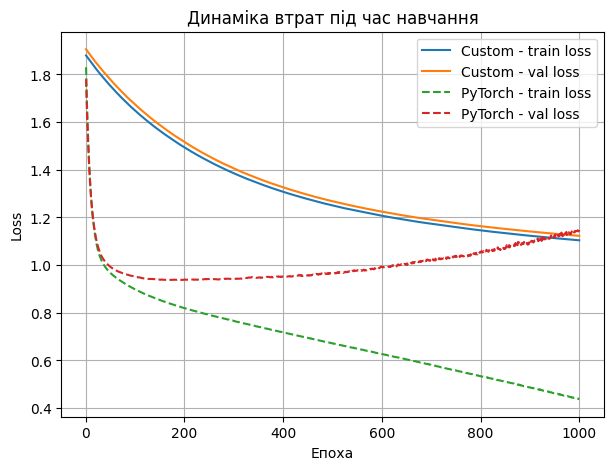

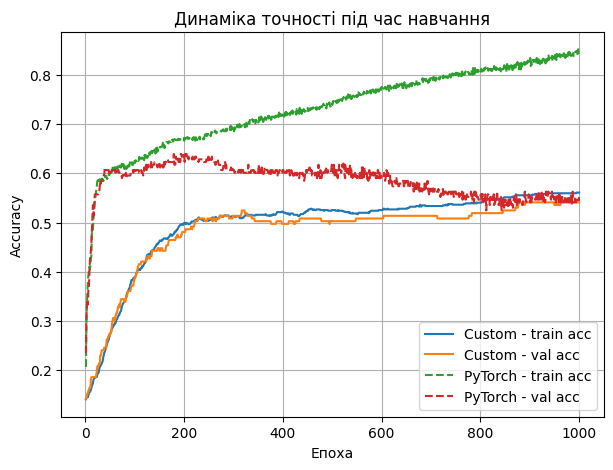

In [8]:
def plot_training_history(history_custom, history_pytorch):
    epochs_range = range(1, len(history_custom['train_loss']) + 1)

    # Графік втрат
    plt.figure(figsize=(7, 5))
    plt.plot(epochs_range, history_custom['train_loss'], label='Custom - train loss')
    plt.plot(epochs_range, history_custom['val_loss'], label='Custom - val loss')
    plt.plot(epochs_range, history_pytorch['train_loss'], label='PyTorch - train loss', linestyle='--')
    plt.plot(epochs_range, history_pytorch['val_loss'], label='PyTorch - val loss', linestyle='--')
    plt.xlabel('Епоха')
    plt.ylabel('Loss')
    plt.title('Динаміка втрат під час навчання')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Графік точності
    plt.figure(figsize=(7, 5))
    plt.plot(epochs_range, history_custom['train_acc'], label='Custom - train acc')
    plt.plot(epochs_range, history_custom['val_acc'], label='Custom - val acc')
    plt.plot(epochs_range, history_pytorch['train_acc'], label='PyTorch - train acc', linestyle='--')
    plt.plot(epochs_range, history_pytorch['val_acc'], label='PyTorch - val acc', linestyle='--')
    plt.xlabel('Епоха')
    plt.ylabel('Accuracy')
    plt.title('Динаміка точності під час навчання')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_history(history_custom, history_torch)

## 9. Матриці неточностей (confusion matrices)

Аналізуємо, які класи плутаються найбільше, та чи схожі патерни помилок
у власній реалізації та у PyTorch-версії.

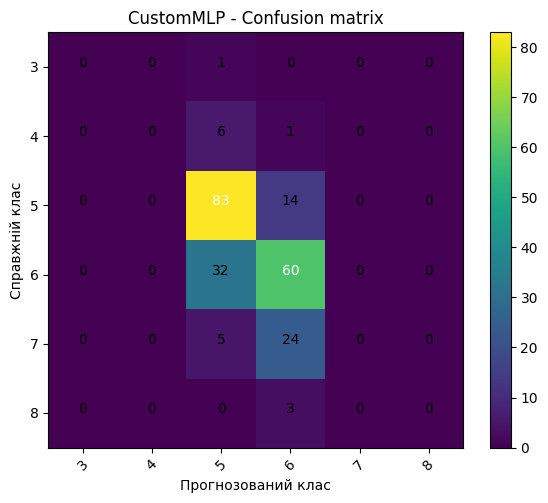

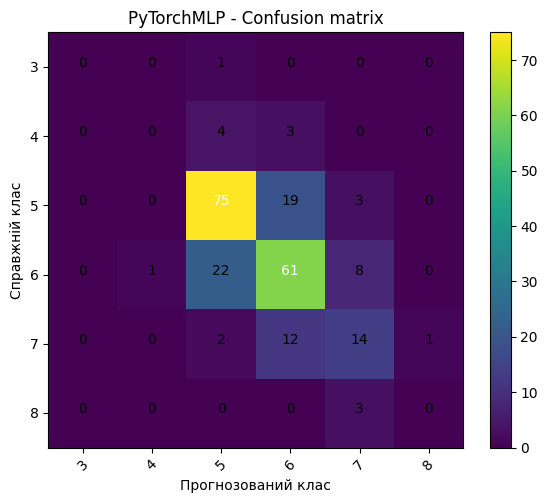

In [9]:
def plot_confusion_matrix(cm, class_names, title='Confusion matrix'):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('Справжній клас')
    plt.xlabel('Прогнозований клас')
    plt.tight_layout()
    plt.show()


cm_custom = confusion_matrix(y_test.cpu().numpy(), y_test_pred_custom)
cm_torch = confusion_matrix(y_test.cpu().numpy(), y_test_pred_torch)

plot_confusion_matrix(cm_custom, class_names, title='CustomMLP - Confusion matrix')
plot_confusion_matrix(cm_torch, class_names, title='PyTorchMLP - Confusion matrix')

## 10. Теоретичні питання

### 1. Похідна комбінації Softmax + Cross-Entropy

Позначимо логіти вихідного шару як $z \in \mathbb{R}^K$.
Softmax:
$$ y_i = \mathrm{softmax}(z)_i = \frac{e^{z_i}}{\sum_j e^{z_j}} $$
Функція втрат для one-hot вектора $y^{true}$:
$$ L = -\sum_i y^{true}_i \log y_i $$
Для правильного класу $k$ маємо $y^{true}_k = 1$, інші 0, тому:
$$ L = -\log y_k $$
Похідна по $z_i$:
$$ \frac{\partial L}{\partial z_i} = y_i - y^{true}_i $$
Тобто градієнт дорівнює різниці між передбаченою ймовірністю та one-hot міткою.

Спрощення відбувається завдяки тому, що похідна softmax і логарифма в cross-entropy
алгебраїчно скорочуються, залишаючи просту форму $y_{pred} - y_{true}$.
Це робить реалізацію градієнта дуже ефективною і чисельно стабільною.

---
### 2. Аналіз зміни градієнтів у глибоких мережах з ReLU

Припустимо, що у кожному шарі 60% нейронів мають від'ємні значення вхідного сигналу,
тобто похідна ReLU для них дорівнює 0. Для решти 40% похідна дорівнює 1.
Тоді при поширенні градієнта назад через шари:
- на кожному шарі частина компонент градієнта занулюється;
- ефективний градієнт для перших шарів зменшується, оскільки все менше нейронів
  пропускають сигнал (і вперед, і назад).

Максимально можливе значення градієнта для ваг першого шару після $N$ шарів ReLU
отримуємо, коли **всі** нейрони активні (тобто всі $z > 0$ і похідна ReLU = 1).
У цьому випадку градієнт не зменшується через активації, але все одно
може масштабуватися матрицями ваг. Якщо позначити матриці ваг як $W^{(l)}$,
то градієнт по активаціях першого шару містить добуток вигляду:
$$ \delta^{(1)} = (W^{(2)})^T (W^{(3)})^T \dots (W^{(N)})^T \delta^{(N)} $$
Тобто норма градієнта обмежена добутком норм матриць ваг. Якщо норми матриць < 1,
градієнти зникають; якщо > 1 — можуть вибухати.

---
### 3. Умовність матричних операцій у backpropagation

У реалізації backpropagation ми використовуємо формулу:
$$ dW = \frac{1}{m} dZ \cdot A_{prev}^T $$
де:
- $dZ$ має розмірність $[\text{out\_dim}, m]$,
- $A_{prev}$ має розмірність $[\text{in\_dim}, m]$,
- $A_{prev}^T$ — $[m, \text{in\_dim}]$.
Отже, результат $dZ \cdot A_{prev}^T$ має розмірність $[\text{out\_dim}, \text{in\_dim}]$ —
саме така, як у матриці ваг $W$.

У загальному випадку, якщо $Z = W X + b$, де:
- $X$ — матриця вхідних даних $[\text{in\_dim}, m]$,
- $W$ — $[\text{out\_dim}, \text{in\_dim}]$,
- $Z$ — $[\text{out\_dim}, m]$,
то градієнт матриці $W$ дорівнює:
$$ dW = \frac{1}{m} dZ \cdot X^T $$
що відповідає ланцюговому правилу для похідної по параметрах лінійного шару.

---
### 4*. Аналіз власних значень гессіана

Для простої двошарової мережі (вхідний шар → прихований → вихідний) матриця Гессіана
відносно ваг першого шару — це матриця других похідних $\frac{\partial^2 L}{\partial W^{(1)} \partial W^{(1)}}$.
У загальному випадку її можна розглядати як велику симетричну матрицю, яка описує
кривизну простору втрат уздовж напрямків ваг.

Власні значення Гессіана пов'язані зі швидкістю збіжності градієнтного спуску:
- великі додатні власні значення означають «круті» напрямки (швидка зміна втрат),
  де потрібно менший крок навчання для стабільності;
- малі власні значення (або близькі до нуля) означають «пласкі» напрямки, де навчання
  відбувається повільно;
- велика розтягнута спектральна характеристика (співвідношення між найбільшим і найменшим
  власними значеннями) робить оптимізацію складною.

У глибоких мережах часто спостерігається проблема **зникаючих градієнтів**:
- добуток багатьох матриць ваг і похідних активацій призводить до того, що
  більшість власних значень Гессіана стають дуже малими;
- це означає, що поверхня втрат має великі пласкі області, де градієнт майже нульовий;
- як наслідок, градієнти на ранніх шарах стають дуже малими, і оновлення ваг
  у цих шарах практично не відбувається.

Це ще одна причина, чому використовують спеціальні ініціалізації (Xavier, He),
нормалізацію батчу та інші техніки, що покращують спектральні властивості Гессіана
і стабілізують градієнти.